# Hair style segmentation (part 1 of hairstyle swap)


MobileNet, project borrowed from [Akirasosa](https://github.com/akirasosa/mobile-semantic-segmentation)

## Set up Google Colab

In [1]:
%ls

sample_data/


In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [0]:
cd bdrive/My\ Drive/app/Hair-segmentation/

In [0]:
from PIL import Image
Image.open(open("images/works.jpg", "rb"))

In [0]:
!pip install torch torchvision

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import scipy.misc
import scipy.ndimage
import random 
import pdb, traceback, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models, transforms, utils
from torchvision.models.vgg import VGG

from PIL import Image
import warnings

warnings.filterwarnings("ignore")

## Data 

### Load dataset

In [8]:
from glob import glob 
import re
import cv2

def _mask_to_img(mask):
  img = re.sub('^data/raw/masks', 'data/raw/images', mask)
  img = re.sub('\.ppm$', '.jpg', img)
  return img 

def _img_to_mask(img):
  mask = re.sub('^data/raw/images', 'data/raw/masks', img)
  mask = re.sub('\.jpg$', '.ppm', mask)
  return mask

def get_images():
  masks = sorted(glob('data/raw/masks/*.ppm'))
  return np.array([_mask_to_img(mask) for mask in masks])

class PartLFW(Dataset):
  def __init__(self, images, transform):
    self.images = images
    self.labels = [_img_to_mask(image) for image in images]
    self.transform = transform
    
      
  def __getitem__(self, index):
    image = cv2.imread(self.images[index])
    label = cv2.imread(self.labels[index])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    label = label #[:,:,0] # Just hair 
    
    seed = random.randint(0, 2**32)
    
    # Transform images 
    random.seed(seed)
    image = Image.fromarray(image)
    image = self.transform(image)
    
    # Transform labels
    random.seed(seed)
    label = Image.fromarray(label)
    label = self.transform(label)
    
    return image, label
  
  def __len__(self):
    return len(self.images)
    
    
    
train_transforms = transforms.Compose([transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                                       transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
                                       transforms.RandomAffine(10.),
                                       transforms.RandomRotation(13.),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor()])

images = get_images()
Kf = KFold(n_splits=5, random_state=1, shuffle=True)

samples = []
print(len(images))

for train_idx, valid_idx in Kf.split(images):
  # Take just one sample (for now)
  train_indices, valid_indices = train_idx, valid_idx  
  break
  
print(len(train_indices), len(valid_indices))
  
trainloader = torch.utils.data.DataLoader(PartLFW(images[train_indices], train_transforms), batch_size=8, shuffle=True, pin_memory=True)
validloader = torch.utils.data.DataLoader(PartLFW(images[valid_indices], valid_transforms), batch_size=1, pin_memory=True)      

2927
2341 586


### Visualize data sample

In [0]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

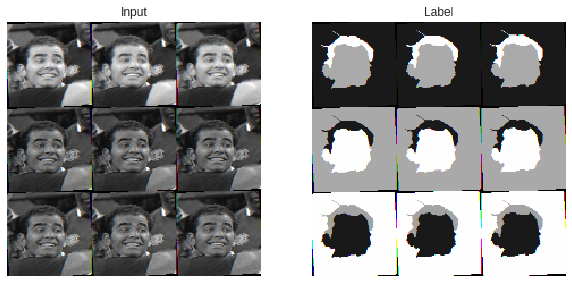

In [0]:
batch = next(iter(trainloader))

images, labels = batch[0], batch[1]

img = images[0].reshape(224, 224, 3)
mask = labels[0].reshape(224, 224, 3)

plot_imgs([img, mask],["Input", "Label"])


## Model

In [0]:
import math

def conv_bn(inp, oup, stride):
  return nn.Sequential(
      nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
      nn.BatchNorm2d(oup),
      nn.ReLU6(inplace=True))

def conv_1x1_bn(inp, oup):
  return nn.Sequential(
      nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
      nn.BatchNorm2d(oup),
      nn.ReLU6(inplace=True))

class InvertedResidual(nn.Module):
  def __init__(self, inp, oup, stride, expand_ratio):
    super(InvertedResidual, self).__init__()
    self.stride = stride
    assert stride in [1, 2]
    
    hidden_dim = round(inp * expand_ratio)
    self.use_res_connect = self.stride == 1 and inp == oup
    
    if expand_ratio == 1:
      self.conv = nn.Sequential(
          
      # dw
      nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
          nn.BatchNorm2d(hidden_dim),
          nn.ReLU6(inplace=True),
          # pw-linear
          nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
          nn.BatchNorm2d(oup),)
    else:
      self.conv = nn.Sequential(
          # pw
          nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
          nn.BatchNorm2d(hidden_dim),
          nn.ReLU6(inplace=True),
          # dw
          nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
          nn.BatchNorm2d(hidden_dim),
          nn.ReLU6(inplace=True),
          # pw-linear
          nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
          nn.BatchNorm2d(oup),)
  
  def forward(self, x):
    if self.use_res_connect:
      return x + self.conv(x)
    else:
      return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          m.weight.data.normal_(0, math.sqrt(2. / n))
          if m.bias is not None:
            m.bias.data.zero_()
          elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
          elif isinstance(m, nn.Linear):
            n = m.weight.size(1)
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
  
class MobileNetV2_unet(nn.Module):
  def __init__(self, pre_trained='weights/mobilenet_v2.pth.tar'):
    super(MobileNetV2_unet, self).__init__()
    
    self.backbone = MobileNetV2()
    
    self.dconv1 = nn.ConvTranspose2d(1280, 96, 4, padding=1, stride=2)
    self.invres1 = InvertedResidual(192, 96, 1, 6)
    self.dconv2 = nn.ConvTranspose2d(96, 32, 4, padding=1, stride=2)
    self.invres2 = InvertedResidual(64, 32, 1, 6)
    self.dconv3 = nn.ConvTranspose2d(32, 24, 4, padding=1, stride=2)
    self.invres3 = InvertedResidual(48, 24, 1, 6)
    self.dconv4 = nn.ConvTranspose2d(24, 16, 4, padding=1, stride=2)
    self.invres4 = InvertedResidual(32, 16, 1, 6)
    self.conv_last = nn.Conv2d(16, 3, 1)
    self.conv_score = nn.Conv2d(3, 3, 1)
    self._init_weights()
    
    if pre_trained is not None:
      self.backbone.load_state_dict(torch.load(pre_trained))
      
  def forward(self, x):
    for n in range(0, 2):
      x = self.backbone.features[n](x)
    x1 = x  
    
    for n in range(2, 4):
      x = self.backbone.features[n](x)
    x2 = x
    
    for n in range(4, 7):
      x = self.backbone.features[n](x)
    x3 = x
    
    for n in range(7, 14):
      x = self.backbone.features[n](x)
    x4 = x
    
    for n in range(14, 19):
      x = self.backbone.features[n](x)
    x5 = x
    
    up1 = torch.cat([x4, self.dconv1(x)], dim=1)
    up1 = self.invres1(up1)
    
    up2 = torch.cat([x3, self.dconv2(up1)], dim=1)
    up2 = self.invres2(up2)
    
    up3 = torch.cat([x2, self.dconv3(up2)], dim=1)
    up3 = self.invres3(up3)
    
    up4 = torch.cat([x1, self.dconv4(up3)], dim=1)
    up4 = self.invres4(up4)
    
    x = self.conv_last(up4)
    x = self.conv_score(x)
    x = torch.sigmoid(x)
    
    return x

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
          m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.01)
        m.bias.data.zero_()

## Train

### Evaluation functions

In [0]:
def color2classes(img):
  new_img = np.zeros((192, 192)).astype(np.uint8)
  for i in range(192):
    for j in range(192):
      if img[i, j, 2] == 255:
        new_img[i, j] = 0
      elif img[i, j, 1] == 255:
        new_img[i, j] = 1
      else:
        new_img[i, j] = 2
  return new_img

global ious 

def iou(y_hat, y):
  try:
    ious = []
    for c in range(3):
      pred_inds = y_hat == c
      target_inds = y == c
      intersection = pred_inds[target_inds].sum()
      union = pred_inds.sum() + target_inds.sum() - intersection
      if union == 0:
        ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
      else:
        ious.append(float(intersection) / max(union, 1))
  except:
    extype, value, tb = sys.exc_info()
    traceback.print_exc()
    pdb.post_mortem(tb)
    
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total


def validation(model, loader, optimizer):
  model.eval()
  running_loss = 0.0
  total_ious = [] 
  pixel_accs = []
  
  
  for inputs, labels in loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
          
    pred = outputs.data.cpu().numpy().reshape(int(224/2), int(224/2), 3) * 255
    pred = cv2.resize(pred.astype(np.uint8), (224, 224))
    
    targ = labels.cpu().numpy().reshape(224, 224, 3) * 255
    targ = cv2.resize(targ.astype(np.uint8), (224, 224))
    
    new_mask = color2classes(targ)
    new_pred = color2classes(pred)
    
    for y_hat, y in zip(new_pred, new_mask):
      total_ious.append(iou(y_hat, y))
      pixel_accs.append(pixel_accuracy(y_hat, y))
        
    running_loss += loss.item() * inputs.size(0)
    
  # Epoch loss 
  epoch_loss = running_loss / len(loader)
  
  # Mean IoU
  total_ious = np.array(total_ious).T
  mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
  # Pixel accuracy
  pixel_acc = np.array(pixel_accs).mean()
  
  return epoch_loss, mean_iou, pixel_acc

### Loss function

In [0]:
from torch.nn.functional import interpolate

def DICE_loss(scale=None):
  def fn(input, target):
    smooth = 1.
    
    if scale is not None:
      scaled = interpolate(input, scale_factor=scale, mode='bilinear', align_corners=False)
      iflat = scaled.view(-1)
    else:
      iflat = input.view(-1)
    
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
  return fn

### Model parameters

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = MobileNetV2_unet(pre_trained=None)
model.to(device)

criterion = DICE_loss(scale=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 120

cuda:0


### IoU, pixel accuracy, and DICE loss before training

In [32]:
loss, iou_score, pixel_score = validation(model, validloader, optimizer)
print("IoU: ", iou_score, " Pixel accuracy: ", pixel_score, " DICE Loss: ", loss)

IoU:  0.24586525463671507  Pixel accuracy:  0.7328665960816032  DICE Loss:  0.4120146595577331


### Train model

In [0]:
import time 

best = 0
for epoch in range(epochs):
  start = time.time()
  
  # train_on_epoch loss 
  model.train()
  running_tloss = 0.0
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    running_tloss += loss.item() * inputs.size(0)
  
  epoch_train_loss = running_tloss / len(trainloader)
  #print("training loss: ", epoch_train_loss)
    
  # valid_on_epoch loss
  """
  model.eval()
  running_vloss = 0.0
  
  for inputs, labels in validloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
    running_vloss += loss.item() * inputs.size(0)
  
  epoch_valid_loss = running_vloss / len(validloader) 
  """
  loss, iou_score, pixel_score = validation(model, validloader, optimizer)
  end = time.time()
  
  print("Epoch: {}/{}.. ".format(epoch+1, epochs),
        "Time: {:.3f}.. ".format(end-start),
        "Training loss: {:.5f}.. ".format(epoch_train_loss),
        "Valid loss {:.5f}.. ".format(loss),
        "Pixel accuracy.. {:.5f}".format(pixel_score),
        "Mean IU.. {:.5f}".format(iou_score))
  
  # Save best model
  if loss > best:
    torch.save(model.state_dict(), "./U-net-bestloss2.pth")
    best = loss
    
    
  #print("validation loss: ", epoch_valid_loss)
  #print("Training loss: ", epoch_train_loss, "Validation loss: ", epoch_valid_loss)

### Save mode

In [0]:
torch.save(model.state_dict(), "./U-net-model2.pth")

### IoU, pixel accuracy, and DICE loss after training

In [22]:
loss, iou_score, pixel_score = validation(model, validloader, optimizer)
print("IoU: ", iou_score, " Pixel accuracy: ", pixel_score, " DICE Loss: ", loss)

IoU:  0.5421345235235296  Pixel accuracy:  0.9415664181005877  DICE Loss:  0.061897943349421634


## Inference

In [0]:
state_dict = torch.load('./U-net-bestloss.pth')
model.load_state_dict(state_dict)

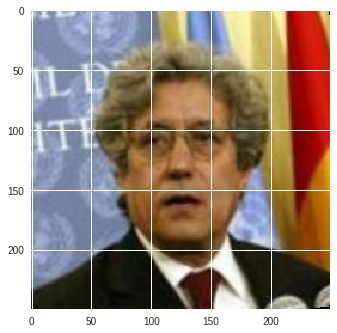

In [23]:
img = "data/raw/images/Adolfo_Aguilar_Zinser_0003.jpg"
test_image = cv2.imread("data/raw/images/Adolfo_Aguilar_Zinser_0003.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.imshow(test_image)

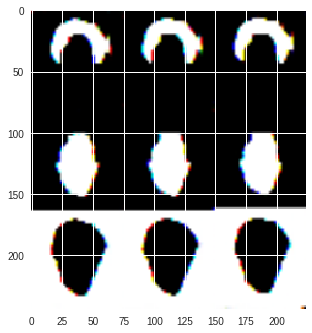

In [25]:
model.eval()

image = Image.fromarray(test_image).convert('RGB')
image = valid_transforms(image)

with torch.no_grad():
  image = image.to(device)
  output = model(image.reshape(1, 3, 224, 224))
  
  prediction = output.cpu().numpy().reshape(int(224/2), int(224/2), 3) * 255
  prediction = cv2.resize(prediction.astype(np.uint8), (224, 244))
  
  plt.imshow(prediction)
  
